In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.preprocessing import power_transform, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
%config InlineBackend.figure_format = 'retina' 

### 0. Boilerplate

In [3]:
worker_lookup_df = pd.read_csv('../data/worker_relationship_jun_20.csv', index_col=[0])
relationship_df = pd.read_csv('../data/output.csv', index_col=[0])
id_address_df = pd.read_csv('../data/id_lookup.csv', index_col=[0])
message_df = pd.read_csv('../data/recent_send_messages.csv', index_col=[0])

In [4]:
df = pd.merge(message_df, id_address_df, left_on = 'from_address', right_on='address')
df = df.rename(columns={'id': 'from_id'})
df = pd.merge(df, id_address_df, left_on = 'to_address', right_on='address')
df = df.rename(columns={'id': 'to_id'}).drop(columns=['address_x', 'address_y', 'height_in_month', 'etl_ts', 'cid'])
df.value = pd.to_numeric(df.value, errors='coerce')
df.value = df['value'] / 1e18

### 1. Calculating network measures

Here, we calculate a range of network importance measures for each node:
* centrality
* in/out-centrality
* number of neighbours

We will then do a principal component analysis on the resulting matrix of importance measures. Note: we do not  include the value of token that's being transferred in our matrix. 

In [6]:
edgelist = df[['from_id', 'to_id', 'value']]
G = nx.from_pandas_edgelist(edgelist, 'from_id', 'to_id', 'value', create_using=nx.DiGraph)

num_neighs = {g[0]:len(g[1]) for g in G.adjacency()}
centrality = nx.degree_centrality(G)
in_centrality = nx.in_degree_centrality(G)
out_centrality = nx.out_degree_centrality(G)
avg_neigh_degree = nx.average_neighbor_degree(G)
clustering_coeff = nx.clustering(G)

df_num_neighs = pd.DataFrame.from_dict(num_neighs, orient='index', columns=['num_neighs'])
df_centrality = pd.DataFrame.from_dict(centrality, orient='index', columns=['centrality'])
df_in_centrality = pd.DataFrame.from_dict(in_centrality, orient='index', columns=['in_centrality'])
df_out_centrality = pd.DataFrame.from_dict(out_centrality, orient='index', columns=['out_centrality'])
df_avg_neigh_degree = pd.DataFrame.from_dict(avg_neigh_degree, orient='index', columns=['avg_neigh_degree'])
df_clustering_coeff = pd.DataFrame.from_dict(clustering_coeff, orient='index', columns=['clustering_coeff'])

In [8]:
dataframe = df_num_neighs\
    .merge(df_centrality, left_index=True, right_index=True)\
    .merge(df_in_centrality, left_index=True, right_index=True)\
    .merge(df_out_centrality, left_index=True, right_index=True)\
    .merge(df_avg_neigh_degree, left_index=True, right_index=True)\
    .merge(df_clustering_coeff, left_index=True, right_index=True)

dataframe = dataframe.join(df.groupby('from_id').sum()['value'], how='left').fillna(0)
dataframe.rename(columns={'value': 'value_spent'}, inplace=True)
dataframe = dataframe.join(df.groupby('to_id').sum()['value'], how='left').fillna(0)    
dataframe.rename(columns={'value': 'value_received'}, inplace=True)

It is necessary to do some transformations as the data is highly skewed (power law). 

In [9]:
pipeline = make_pipeline(PowerTransformer(), StandardScaler(), PCA(n_components=2))
pipeline.fit(dataframe[dataframe.columns[0:-2]])
data_pc = pipeline.transform(dataframe[dataframe.columns[0:-2]])

Text(0.5, 1.0, 'Dark - low expenditure; Yellow - high expenditure')

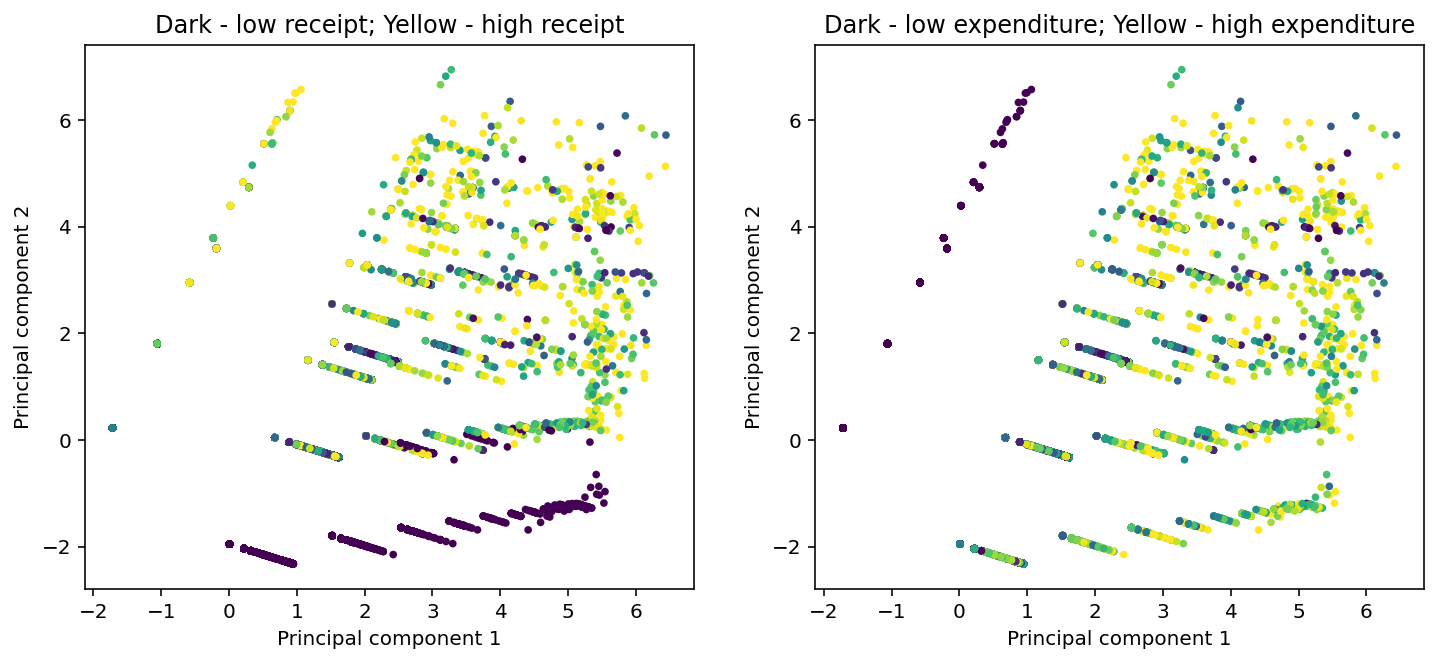

In [116]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.scatter(data_pc[:,0], data_pc[:,1], c=np.log1p(dataframe.value_received), vmin=0, vmax=8, cmap='viridis', s=8)
# ax1.set_xscale('log')
ax1.set_xlabel('Principal component 1')
ax1.set_ylabel('Principal component 2')

ax2.scatter(data_pc[:,0], data_pc[:,1], c=np.log1p(dataframe.value_spent), vmin=0, vmax=8, cmap='viridis', s=8)
# ax2.set_xscale('log')
ax2.set_xlabel('Principal component 1')
ax2.set_ylabel('Principal component 2')
ax1.set_title('Dark - low receipt; Yellow - high receipt')
ax2.set_title('Dark - low expenditure; Yellow - high expenditure')

The actors at the top left corner are high net receivers of token, with very different network structure from the average.

The actors at the bottom right corner are low net receivers of token, with very different network structure from the average.

There is a big blob of points in the middle. These are actors who behave more or less on average.

Text(0.5, 1.0, 'Dark - low average degree; Yellow - high average degree')

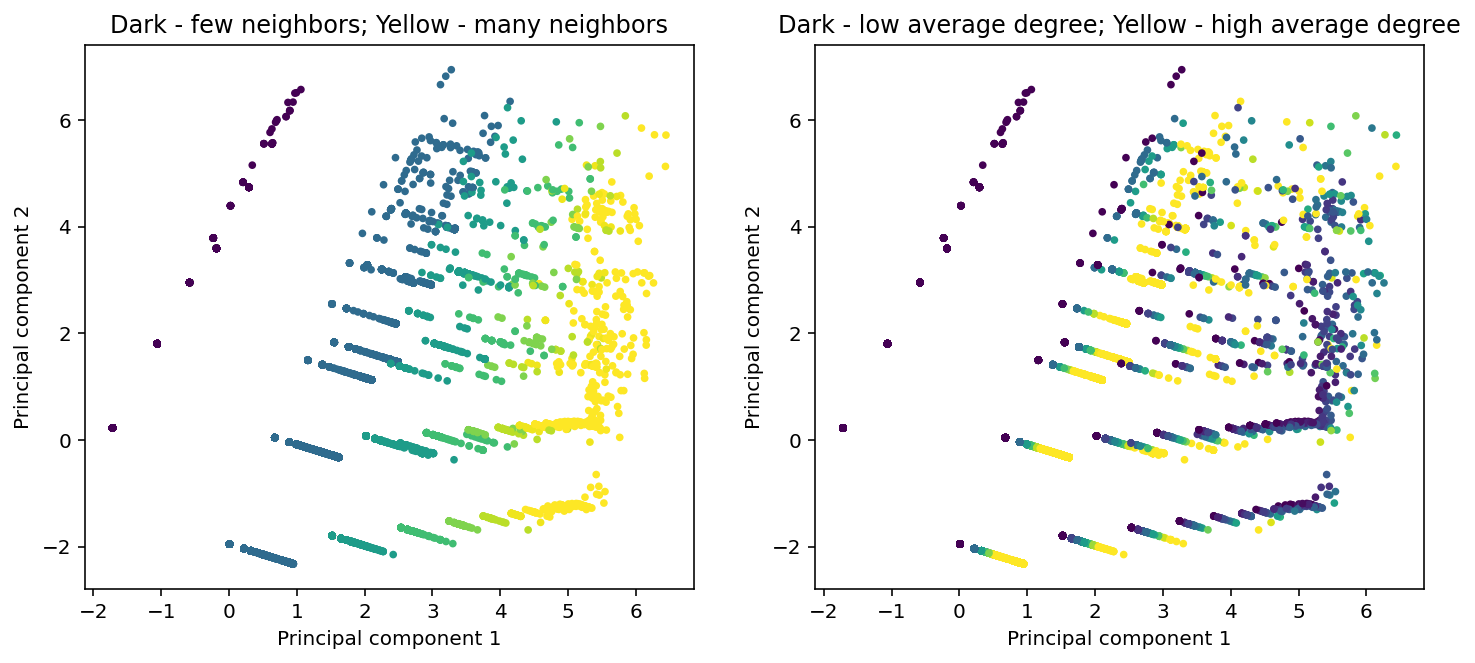

In [34]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.scatter(data_pc[:,0], data_pc[:,1], c=np.log1p(dataframe.num_neighs), vmin=0, vmax=2, cmap='viridis', s=8)
# ax1.set_xscale('log')
ax1.set_xlabel('Principal component 1')
ax1.set_ylabel('Principal component 2')

ax2.scatter(data_pc[:,0], data_pc[:,1], c=np.log1p(dataframe.avg_neigh_degree), vmin=0, vmax=2, cmap='viridis', s=8)
# ax2.set_xscale('log')
ax2.set_xlabel('Principal component 1')
ax2.set_ylabel('Principal component 2')
ax1.set_title('Dark - few neighbors; Yellow - many neighbors')
ax2.set_title('Dark - low average degree; Yellow - high average degree')

/Users/beng/miniforge3/envs/tf/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Dark - low out-centrality; Yellow - high out-centrality')

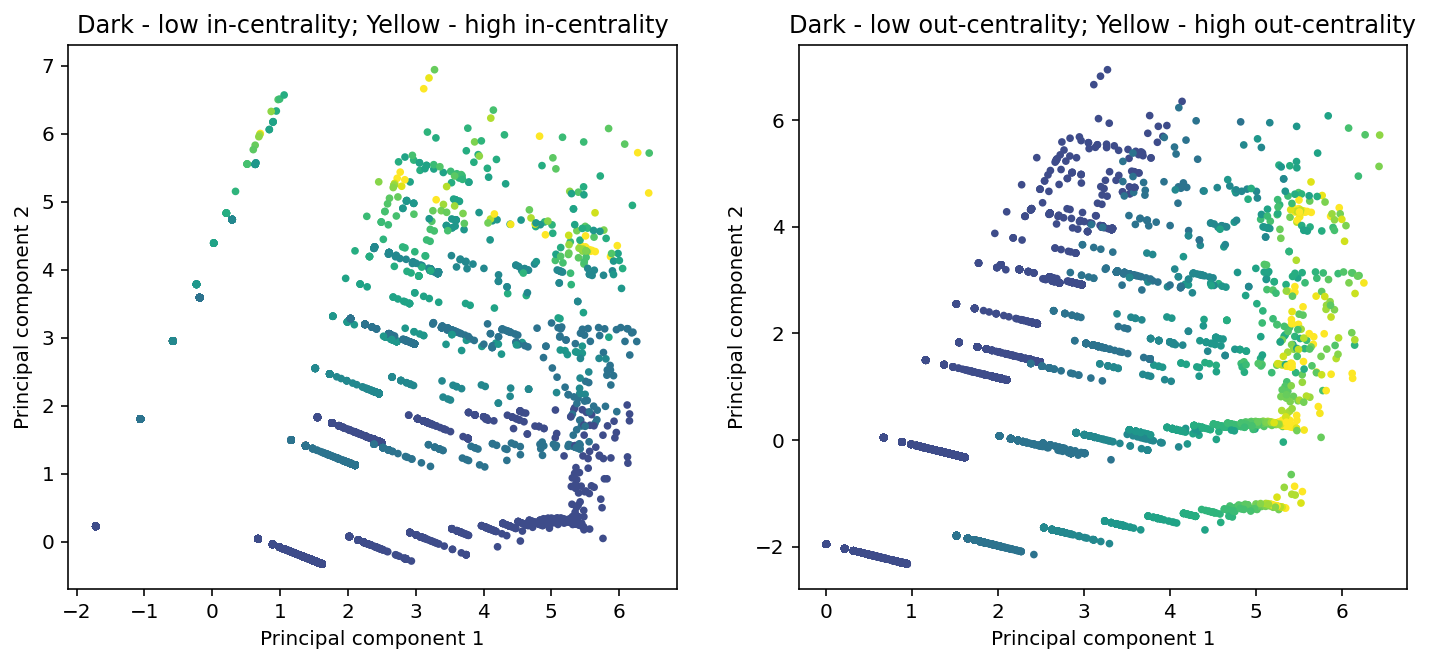

In [33]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.scatter(data_pc[:,0], data_pc[:,1], c=np.log10(dataframe.in_centrality), vmin=-5, vmax=-3, cmap='viridis', s=8)
# ax1.set_xscale('log')
ax1.set_xlabel('Principal component 1')
ax1.set_ylabel('Principal component 2')

ax2.scatter(data_pc[:,0], data_pc[:,1], c=np.log10(dataframe.out_centrality), vmin=-5, vmax=-3, cmap='viridis', s=8)
# ax2.set_xscale('log')
ax2.set_xlabel('Principal component 1')
ax2.set_ylabel('Principal component 2')
ax1.set_title('Dark - low in-centrality; Yellow - high in-centrality')
ax2.set_title('Dark - low out-centrality; Yellow - high out-centrality')